# Machine Learning

## Set up

In [1]:
# Set up folders
from EDA_functions import folders_set_up
import os

# Work with datarames
import pandas as pd
import numpy as np

# Charts
import seaborn as sns
from matplotlib import pyplot as plt

# X, Y preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SVR
from sklearn.svm import SVR

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout
from keras.optimizers import Adam, SGD

# Pipeline
from sklearn.pipeline import Pipeline

# Evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Time
import time

#from scipy.sparse import spmatrixc

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Light GBM
# import lightgbm as lgb

### Folders
Run the code below if you have the following structure:
- Group-project: GitHub folder
- 01 Input
- 02 Output

In [3]:
analysis_folder, input_folder, output_folder = folders_set_up.generate_folders()

## Import and merge data

### Datasets

In [4]:
#Title-level dataset with embeddings
title_embeddings_df = pd.read_pickle(
    os.path.join(output_folder, 'English_fiction_pre_PCA_3_with_av_pool_embeddings')
)

title_embeddings_df.columns

Index(['index', 'Title', 'description', 'authors', 'image', 'previewLink',
       'publisher', 'infoLink', 'categories', 'reviews number',
       'average rating', 'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding'],
      dtype='object')

### Format data

In [5]:
title_embeddings_df.dtypes

index                     int64
Title                    object
description              object
authors                  object
image                    object
previewLink              object
publisher                object
infoLink                 object
categories               object
reviews number            int64
average rating          float64
median rating           float64
min review date          object
max review date          object
weighted rating         float64
date                     object
year                    float64
description_language     object
Embedding                object
dtype: object

#### Date

In [6]:
dates_columns = ['min review date', 'max review date', 'date']

for date in dates_columns:
    # get date from strings with time
    title_embeddings_df[date] = title_embeddings_df[date].str.split().str[0]
    # convert in datetime
    title_embeddings_df[date] = pd.to_datetime(title_embeddings_df[date])

In [7]:
title_embeddings_df[dates_columns].isna().sum()

min review date    0
max review date    0
date               0
dtype: int64

In [8]:
# what is the max and minimu of the ratings?
print(title_embeddings_df['weighted rating'].min())
print(title_embeddings_df['weighted rating'].max())

1.8228249664151188
4.886083503427672


In [9]:
# NOTE: we work on a subset of data for now to make the ML run faster
#title_embeddings_df = title_embeddings_df.sample(n=1000, random_state=42)

#### Image embeddings
These need may need to be transformed in from arrays to columns if the model we use is not NN

### Indices

In [10]:
title_embeddings_df['index_key'] = title_embeddings_df['index']
title_embeddings_df

,index,Title,description,authors,image,previewLink,publisher,infoLink,categories,reviews number,average rating,median rating,min review date,max review date,weighted rating,date,year,description_language,Embedding,index_key
0,3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['fiction'],32,3.718750,5.0,2005-02-14,2006-07-01,3.938400,2005-02-01,2005.0,English,"[0.5179044, -0.7533603, -1.1291503, -0.4418345...",3
1,24,The Forbidden Stories of Marta Veneranda,"Marta Veneranda, a Latina neoyorkina, finds th...",['Sonia Rivera-Valdes'],http://books.google.com/books/content?id=A7aYb...,http://books.google.nl/books?id=A7aYbAvagu8C&p...,Seven Stories Press,http://books.google.nl/books?id=A7aYbAvagu8C&d...,['fiction'],1,5.000000,5.0,2005-01-24,2005-01-24,4.306145,2001-03-06,2001.0,English,"[0.706188, -0.4773652, -0.17887038, 0.07989502...",24
2,42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,['juvenile fiction'],17,4.235294,5.0,2002-10-22,2011-05-25,4.256189,2002-11-01,2002.0,English,"[2.294651, -0.24902871, -0.6188333, -0.7722471...",42
3,49,"Eight Men And A Lady (Elizabeth Sinclair, Harl...",Eight Men And A Lady by Elizabeth Sinclair rel...,['Elizabeth Sinclair'],http://books.google.com/books/content?id=Z6uzJ...,http://books.google.nl/books?id=Z6uzJgLWViUC&q...,Harlequin Treasury-Harlequin American Romance 90s,http://books.google.nl/books?id=Z6uzJgLWViUC&d...,['fiction'],2,5.000000,5.0,1998-04-16,2000-05-14,4.336313,1997-01-01,1997.0,English,"[0.37794992, -0.6178984, -0.81393754, -0.66795...",49
4,73,Night World: Daughters Of Darkness,"""There’s something strange about the new girls...",['L.J. Smith'],http://books.google.com/books/content?id=c9icD...,http://books.google.nl/books?id=c9icDQAAQBAJ&p...,Simon and Schuster,http://books.google.nl/books?id=c9icDQAAQBAJ&d...,['juvenile fiction'],134,4.768657,5.0,1996-08-07,2012-09-18,4.701517,2016-12-06,2016.0,English,"[0.34032565, -2.1706967, -0.21470371, -0.10447...",73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26769,212361,Calder Pride,The Long-Awaited Addition to the Beloved Calde...,['Janet Dailey'],http://books.google.com/books/content?id=nlsgd...,http://books.google.com/books?id=nlsgd2-kGq4C&...,Harper Collins,https://play.google.com/store/books/details?id...,['fiction'],28,4.035714,5.0,1999-09-30,2012-04-04,4.137453,2009-03-17,2009.0,English,"[1.1648176, 0.56768346, -0.22511423, -0.185316...",212361
26770,212365,The Road Back,The sequel to the masterpiece All Quiet on the...,['Erich Maria Remarque'],http://books.google.com/books/content?id=obZdA...,http://books.google.com/books?id=obZdAAAAQBAJ&...,Random House Trade Paperbacks,http://books.google.com/books?id=obZdAAAAQBAJ&...,['fiction'],17,4.705882,5.0,1997-05-17,2012-01-23,4.466716,1998-01-27,1998.0,English,"[0.023786038, -1.9050528, -0.38564998, 0.14921...",212365
26771,212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,http://books.google.com/books?id=UbSFBAAAQBAJ&...,Vintage,https://play.google.com/store/books/details?id...,['fiction'],1,4.000000,4.0,2012-01-26,2012-01-26,4.260690,2015-03-17,2015.0,English,"[2.2700834, -0.11750376, -2.0253444, -1.039558...",212394
26772,212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,http://books.google.com/books?id=J7M-NwAACAAJ&...,['juvenile fiction'

In [11]:
title_embeddings_df = title_embeddings_df.set_index('index_key')

In [12]:
title_embeddings_df

,index,Title,description,authors,image,previewLink,publisher,infoLink,categories,reviews number,average rating,median rating,min review date,max review date,weighted rating,date,year,description_language,Embedding
index_key,,,,,,,,,,,,,,,,,,,
3,3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['fiction'],32,3.718750,5.0,2005-02-14,2006-07-01,3.938400,2005-02-01,2005.0,English,"[0.5179044, -0.7533603, -1.1291503, -0.4418345..."
24,24,The Forbidden Stories of Marta Veneranda,"Marta Veneranda, a Latina neoyorkina, finds th...",['Sonia Rivera-Valdes'],http://books.google.com/books/content?id=A7aYb...,http://books.google.nl/books?id=A7aYbAvagu8C&p...,Seven Stories Press,http://books.google.nl/books?id=A7aYbAvagu8C&d...,['fiction'],1,5.000000,5.0,2005-01-24,2005-01-24,4.306145,2001-03-06,2001.0,English,"[0.706188, -0.4773652, -0.17887038, 0.07989502..."
42,42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,['juvenile fiction'],17,4.235294,5.0,2002-10-22,2011-05-25,4.256189,2002-11-01,2002.0,English,"[2.294651, -0.24902871, -0.6188333, -0.7722471..."
49,49,"Eight Men And A Lady (Elizabeth Sinclair, Harl...",Eight Men And A Lady by Elizabeth Sinclair rel...,['Elizabeth Sinclair'],http://books.google.com/books/content?id=Z6uzJ...,http://books.google.nl/books?id=Z6uzJgLWViUC&q...,Harlequin Treasury-Harlequin American Romance 90s,http://books.google.nl/books?id=Z6uzJgLWViUC&d...,['fiction'],2,5.000000,5.0,1998-04-16,2000-05-14,4.336313,1997-01-01,1997.0,English,"[0.37794992, -0.6178984, -0.81393754, -0.66795..."
73,73,Night World: Daughters Of Darkness,"""There’s something strange about the new girls...",['L.J. Smith'],http://books.google.com/books/content?id=c9icD...,http://books.google.nl/books?id=c9icDQAAQBAJ&p...,Simon and Schuster,http://books.google.nl/books?id=c9icDQAAQBAJ&d...,['juvenile fiction'],134,4.768657,5.0,1996-08-07,2012-09-18,4.701517,2016-12-06,2016.0,English,"[0.34032565, -2.1706967, -0.21470371, -0.10447..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,212361,Calder Pride,The Long-Awaited Addition to the Beloved Calde...,['Janet Dailey'],http://books.google.com/books/content?id=nlsgd...,http://books.google.com/books?id=nlsgd2-kGq4C&...,Harper Collins,https://play.google.com/store/books/details?id...,['fiction'],28,4.035714,5.0,1999-09-30,2012-04-04,4.137453,2009-03-17,2009.0,English,"[1.1648176, 0.56768346, -0.22511423, -0.185316..."
212365,212365,The Road Back,The sequel to the masterpiece All Quiet on the...,['Erich Maria Remarque'],http://books.google.com/books/content?id=obZdA...,http://books.google.com/books?id=obZdAAAAQBAJ&...,Random House Trade Paperbacks,http://books.google.com/books?id=obZdAAAAQBAJ&...,['fiction'],17,4.705882,5.0,1997-05-17,2012-01-23,4.466716,1998-01-27,1998.0,English,"[0.023786038, -1.9050528, -0.38564998, 0.14921..."
212394,212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,http://books.google.com/books?id=UbSFBAAAQBAJ&...,Vintage,https://play.google.com/store/books/details?id...,['fiction'],1,4.000000,4.0,2012-01-26,2012-01-26,4.260690,2015-03-17,2015.0,English,"[2.2700834, -0.11750376, -2.0253444, -1.039558..."


### Clean data
Most of the cleaning is done in '02 Consolidate books dataset':
- English description
- category containing the word 'fiction'
- non-missing date
- non-missing author
- non-missing publisher
- non-missing cover image

## X and y set up

### Train test split

In [13]:
title_embeddings_df.columns

Index(['index', 'Title', 'description', 'authors', 'image', 'previewLink',
       'publisher', 'infoLink', 'categories', 'reviews number',
       'average rating', 'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding'],
      dtype='object')

In [14]:
# Create X and y including all X features and all all teh possible target variables
# NOTE: we will have to add the description PCA in X_features
X_columns = ['year', 'Embedding', 'index', 'Title']

X = title_embeddings_df[X_columns]
y = title_embeddings_df[['average rating', 'weighted rating']]

In [15]:
X.columns

Index(['year', 'Embedding', 'index', 'Title'], dtype='object')

In [16]:
y.columns

Index(['average rating', 'weighted rating'], dtype='object')

In [17]:
# Create train test split

# Need to create train test split for different combinations of data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size= 0.2, 
    random_state= 42,
)

In [18]:
# store indices of train test split for the NLP of description
train_indices = X_train[['Title', 'index']]
test_indices = X_test[['Title', 'index']]

train_indices.to_csv(
    os.path.join(output_folder, 'train_indices.csv')
)


test_indices.to_csv(
    os.path.join(output_folder, 'test_indices.csv')
)

### y cuts

In [19]:
# Y train with average rating
y_avg_r_train = y_train['average rating']
y_avg_r_test = y_test['average rating']

# Y train with weighted rating
y_wr_train = y_train['weighted rating']
y_wr_test = y_test['weighted rating']

### Image embeddings X
Transform the arrays into columns so that they can feed into the models

In [20]:
X_images_train = X_train['Embedding'].apply(pd.Series)
X_images_test = X_test['Embedding'].apply(pd.Series)

# Rename columns
X_images_train = X_images_train.add_prefix('image_')
X_images_test = X_images_test.add_prefix('image_')

In [21]:
X_images_train

,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,image_246,image_247,image_248,image_249,image_250,image_251,image_252,image_253,image_254,image_255
index_key,,,,,,,,,,,,,,,,,,,,,
19757,1.310540,0.253238,-0.208362,-0.584103,-0.794551,-1.803357,-2.700018,-0.848385,0.949902,0.030431,...,-0.475167,-0.116055,0.735540,-2.354414,0.956939,-1.065875,-0.428229,-0.285047,1.098027,-1.029737
111405,1.078856,-0.691140,-0.908770,-0.527087,-1.044688,-0.904328,0.210946,-1.238919,2.290273,-0.155667,...,0.833435,-1.053398,-2.031961,-2.716383,0.817275,-0.434370,-1.456125,0.112614,0.199815,-2.946273
12269,0.350093,-0.135313,0.512653,0.466054,0.326599,0.014968,-2.224684,-0.740723,0.951188,0.978717,...,1.401945,-0.270900,-1.967142,-0.814089,0.170715,0.335253,-0.030882,-0.557203,0.037506,-1.951925
186303,4.560193,0.550376,-0.331547,-2.215812,0.023501,-0.370375,-0.838666,-0.905349,2.655245,0.461321,...,1.073267,0.354717,-1.745163,-2.610591,-0.239567,-1.714204,-0.914772,-0.354720,0.098914,-3.272672
134045,2.236698,-0.498289,-1.946595,-0.618339,-2.150359,1.257699,-1.547900,-1.492419,2.133226,1.513557,...,0.192120,-0.731990,-3.023546,-2.410438,-0.701821,-0.403381,0.522945,0.256027,1.826598,-3.091393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167206,0.998582,-1.018484,-0.603367,-0.467136,0.090738,-1.786356,-1.359131,-0.057187,-0.699324,-0.277699,...,0.967072,-0.407894,0.675619,-2.690143,0.811195,0.162421,-0.319673,-0.655105,1.837679,-2.292945
40262,0.993674,-0.236895,-1.161556,-0.831213,-0.535987,1.596271,-1.988977,-0.020737,0.298276,0.706597,...,1.235213,-0.146208,-1.484007,-1.698481,-0.935188,-0.480799,0.807755,0.346888,1.523457,-1.739759
7002,0.622462,-0.793748,-0.837395,-0.745482,-0.137351,0.551706,0.313828,-0.853430,0.280148,-0.483826,...,1.114822,-0.845614,-1.312257,-0.366303,-0.078197,1.005683,0.627290,-1.296975,1.453560,-0.719741


### Description from NMF

#### Import data

In [22]:
# Description NLP test
NMF_df_test = pd.read_csv(
    os.path.join(output_folder, 'X_test_NMF_topics_100.csv')
)



In [23]:
# Set indices as in train test split
NMF_df_test = NMF_df_test.set_index('index')

NMF_df_test.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       ...
       'NMF_90', 'NMF_91', 'NMF_92', 'NMF_93', 'NMF_94', 'NMF_95', 'NMF_96',
       'NMF_97', 'NMF_98', 'NMF_99'],
      dtype='object', length=118)

In [24]:
NMF_df_test.index

Index([   115,    209,    330,    333,    371,    381,    441,    490,    507,
          549,
       ...
       211852, 211860, 211945, 211952, 211970, 212041, 212144, 212256, 212260,
       212333],
      dtype='int64', name='index', length=5355)

In [25]:
X_images_test.index.sort_values()

Index([   115,    209,    330,    333,    371,    381,    441,    490,    507,
          549,
       ...
       211852, 211860, 211945, 211952, 211970, 212041, 212144, 212256, 212260,
       212333],
      dtype='int64', name='index_key', length=5355)

In [26]:
# Description NLP train
NMF_df_train = pd.read_csv(
    os.path.join(output_folder, 'X_train_NMF_topics_100.csv')
)

NMF_df_train = NMF_df_train.set_index('index')

NMF_df_train.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       ...
       'NMF_90', 'NMF_91', 'NMF_92', 'NMF_93', 'NMF_94', 'NMF_95', 'NMF_96',
       'NMF_97', 'NMF_98', 'NMF_99'],
      dtype='object', length=118)

#### Keep relevant variables

In [27]:
NMF_df_train.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       ...
       'NMF_90', 'NMF_91', 'NMF_92', 'NMF_93', 'NMF_94', 'NMF_95', 'NMF_96',
       'NMF_97', 'NMF_98', 'NMF_99'],
      dtype='object', length=118)

In [28]:
# Define columns to keep
columns_to_keep = [col for col in NMF_df_train.columns if col.startswith('NMF_')]

NMF_df_train = NMF_df_train[columns_to_keep]
NMF_df_test = NMF_df_test[columns_to_keep]

### Description from tSDV

#### Import data

In [29]:
# Description NLP test
NLP_df_test = pd.read_csv(
    os.path.join(output_folder, 'X_test_tSVD_3000.csv')
)

# Set indices as in train test split
NLP_df_test = NLP_df_test.set_index('index')

NLP_df_test.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3018)

In [30]:
NLP_df_test

,Title,description,authors,image,previewLink,publisher,infoLink,categories,reviews number,average rating,...,tSVD2991,tSVD2992,tSVD2993,tSVD2994,tSVD2995,tSVD2996,tSVD2997,tSVD2998,tSVD2999,tSVD3000
index,,,,,,,,,,,,,,,,,,,,,
115,From Potter's Field,"The sixth book in the Kay Scarpetta series, fr...",['Patricia Cornwell'],http://books.google.com/books/content?id=prefg...,http://books.google.nl/books?id=prefgSxnGOwC&p...,Hachette UK,https://play.google.com/store/books/details?id...,['fiction'],157,3.783439,...,0.004673,0.011035,0.000885,0.011355,0.003110,-0.009888,0.001707,-0.000568,0.000850,0.021092
209,Riverworld and Other Stories,Three stories of a world shared by resurrected...,['Philip José Farmer'],http://books.google.com/books/content?id=TP4oD...,http://books.google.nl/books?id=TP4oDwAAQBAJ&p...,Open Road Media,https://play.google.com/store/books/details?id...,['fiction'],7,4.285714,...,0.000682,-0.000072,-0.007662,0.010220,0.001084,-0.007470,-0.006064,0.012055,-0.007764,0.011430
330,Kenny Doin' Just Fine,"KENNY DOIN' JUST FINE Miriam Greenfield, a pro...",['Sadie Wernick Hurwitz'],http://books.google.com/books/content?id=D6Wgi...,http://books.google.nl/books?id=D6WgitXrr8sC&p...,iUniverse,http://books.google.nl/books?id=D6WgitXrr8sC&d...,['fiction'],1,5.000000,...,-0.005573,-0.004538,0.000019,0.002786,-0.015920,0.004716,-0.000231,-0.003591,0.000867,-0.001421
333,Harry on the Rocks,Harry and his boat become stranded on an islan...,['Susan Meddaugh'],http://books.google.com/books/content?id=u5r79...,http://books.google.nl/books?id=u5r79DAUeIYC&q...,Houghton Mifflin Harcourt,http://books.google.nl/books?id=u5r79DAUeIYC&d...,['juvenile fiction'],2,5.000000,...,0.003240,-0.001592,-0.003397,0.001563,0.008503,0.011397,-0.003413,-0.004257,0.006653,-0.002277
371,The National Review Treasury of Classic Childr...,"A collection of over forty stories, tales, poe...","['William F. Buckley, Jr.']",http://books.google.com/books/content?id=NZm7P...,http://books.google.nl/books?id=NZm7PAAACAAJ&d...,Isi Books,http://books.google.nl/books?id=NZm7PAAACAAJ&d...,['juvenile fiction'],3,5.000000,...,-0.002185,-0.001413,0.003879,0.004376,0.000110,0.002358,0.005980,0.005749,-0.000960,-0.003924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212041,Man For Maggie Moore (Montana Matchmakers) (Ha...,You don't know what love is until you have los...,['Steven Labree'],http://books.google.com/books/content?id=NZpeJ...,http://books.google.com/books?id=NZpeJhtmGo8C&...,Steven LaBree,http://books.google.com/books?id=NZpeJhtmGo8C&...,['fiction'],3,4.666667,...,0.004356,0.004014,0.000388,-0.010747,-0.012375,-0.001525,0.006544,0.013144,0.003183,-0.006146
212144,Prancing Tiger,"To clear the name of his ex-girlfriend's son, ...",['Philip Singerman'],http://books.google.com/books/content?id=68R7S...,http://books.google.com/books?id=68R7SppHYHcC&...,William Morrow,http://books.google.com/books?id=68R7SppHYHcC&...,['fiction'],4,4.250000,...,0.011748,-0.000504,0.006213,-0.006230,-0.008297,-0.009560,-0.002252,0.006993,0.007963,-0.001916
212256,Nude Men: A Novel,The internationally acclaimed debut of a novel...,['Amanda Filipacchi'],http://books.google.com/books/content?id=uM-1A...,http://books.google.com/books?id=uM-1AwAAQBAJ&...,Open Road Media,https://play.google.com/store/books/details?id...,['fiction'],23,3.739130,...,-0.010690,0.012784,-0.001923,0.008254,-0.002761,-0.003366,0.018299,-0.007997,0.004508,0.007875


In [31]:
# Description NLP train
NLP_df_train = pd.read_csv(
    os.path.join(output_folder, 'X_train_tSVD_3000.csv')
)

NLP_df_train = NLP_df_train.set_index('index')

NLP_df_train.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3018)

In [32]:
NLP_df_train

,Title,description,authors,image,previewLink,publisher,infoLink,categories,reviews number,average rating,...,tSVD2991,tSVD2992,tSVD2993,tSVD2994,tSVD2995,tSVD2996,tSVD2997,tSVD2998,tSVD2999,tSVD3000
index,,,,,,,,,,,,,,,,,,,,,
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['fiction'],32,3.718750,...,0.001714,-0.012096,0.012755,0.004345,0.016297,0.022422,0.026395,-0.001808,-0.028102,0.011717
24,The Forbidden Stories of Marta Veneranda,"Marta Veneranda, a Latina neoyorkina, finds th...",['Sonia Rivera-Valdes'],http://books.google.com/books/content?id=A7aYb...,http://books.google.nl/books?id=A7aYbAvagu8C&p...,Seven Stories Press,http://books.google.nl/books?id=A7aYbAvagu8C&d...,['fiction'],1,5.000000,...,0.000900,0.002294,-0.002052,-0.013243,-0.002329,-0.005818,-0.000012,0.007939,-0.024247,-0.006868
42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,['juvenile fiction'],17,4.235294,...,-0.002241,-0.007230,-0.005164,0.000416,-0.007837,-0.002487,-0.004066,0.010140,-0.007082,0.001236
49,"Eight Men And A Lady (Elizabeth Sinclair, Harl...",Eight Men And A Lady by Elizabeth Sinclair rel...,['Elizabeth Sinclair'],http://books.google.com/books/content?id=Z6uzJ...,http://books.google.nl/books?id=Z6uzJgLWViUC&q...,Harlequin Treasury-Harlequin American Romance 90s,http://books.google.nl/books?id=Z6uzJgLWViUC&d...,['fiction'],2,5.000000,...,0.004947,-0.003206,0.011330,-0.004898,-0.002988,0.001996,-0.008123,-0.000639,-0.016424,-0.004971
73,Night World: Daughters Of Darkness,"""There’s something strange about the new girls...",['L.J. Smith'],http://books.google.com/books/content?id=c9icD...,http://books.google.nl/books?id=c9icDQAAQBAJ&p...,Simon and Schuster,http://books.google.nl/books?id=c9icDQAAQBAJ&d...,['juvenile fiction'],134,4.768657,...,0.000070,0.003473,-0.013758,0.000954,-0.011287,-0.008795,0.003780,0.002349,-0.013346,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,Calder Pride,The Long-Awaited Addition to the Beloved Calde...,['Janet Dailey'],http://books.google.com/books/content?id=nlsgd...,http://books.google.com/books?id=nlsgd2-kGq4C&...,Harper Collins,https://play.google.com/store/books/details?id...,['fiction'],28,4.035714,...,-0.003849,-0.000571,0.001393,-0.001693,-0.012675,-0.000349,0.002634,-0.004115,0.004868,-0.006720
212365,The Road Back,The sequel to the masterpiece All Quiet on the...,['Erich Maria Remarque'],http://books.google.com/books/content?id=obZdA...,http://books.google.com/books?id=obZdAAAAQBAJ&...,Random House Trade Paperbacks,http://books.google.com/books?id=obZdAAAAQBAJ&...,['fiction'],17,4.705882,...,0.014579,-0.010071,-0.008840,0.011693,0.006862,-0.001960,0.004995,-0.007247,-0.013905,-0.001202
212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,http://books.google.com/books?id=UbSFBAAAQBAJ&...,Vintage,https://play.google.com/store/books/details?id...,['fiction'],1,4.000000,...,0.007651,0.005601,0.000670,-0.010949,-0.012086,0.002205,-0.004838,-0.008230,0.000084,-0.002611


#### Keep relevant variables

In [33]:
columns_to_keep = [col for col in NLP_df_test.columns if col.startswith('tSVD')]

NLP_df_train = NLP_df_train[columns_to_keep]
NLP_df_test = NLP_df_test[columns_to_keep]

In [34]:
NLP_df_train

,tSVD1,tSVD2,tSVD3,tSVD4,tSVD5,tSVD6,tSVD7,tSVD8,tSVD9,tSVD10,...,tSVD2991,tSVD2992,tSVD2993,tSVD2994,tSVD2995,tSVD2996,tSVD2997,tSVD2998,tSVD2999,tSVD3000
index,,,,,,,,,,,,,,,,,,,,,
3,0.129603,-0.038296,-0.063023,0.002653,-0.035225,0.004487,-0.033247,0.006327,0.040408,0.035931,...,0.001714,-0.012096,0.012755,0.004345,0.016297,0.022422,0.026395,-0.001808,-0.028102,0.011717
24,0.105464,-0.019206,-0.016426,-0.003522,0.027940,-0.001382,-0.020538,0.003146,-0.013301,-0.015466,...,0.000900,0.002294,-0.002052,-0.013243,-0.002329,-0.005818,-0.000012,0.007939,-0.024247,-0.006868
42,0.110316,-0.032971,-0.038233,-0.010302,0.009022,-0.016867,-0.066746,0.042483,0.019502,0.016915,...,-0.002241,-0.007230,-0.005164,0.000416,-0.007837,-0.002487,-0.004066,0.010140,-0.007082,0.001236
49,0.043620,-0.010660,-0.049538,0.428472,-0.049904,-0.034815,-0.042501,-0.027805,-0.038459,-0.016390,...,0.004947,-0.003206,0.011330,-0.004898,-0.002988,0.001996,-0.008123,-0.000639,-0.016424,-0.004971
73,0.112533,-0.023843,-0.024143,-0.009996,0.020481,0.020480,0.000434,0.000725,-0.014176,-0.008300,...,0.000070,0.003473,-0.013758,0.000954,-0.011287,-0.008795,0.003780,0.002349,-0.013346,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,0.182936,-0.055312,-0.095027,0.006525,-0.008528,0.031805,-0.063892,0.001145,0.053651,-0.010439,...,-0.003849,-0.000571,0.001393,-0.001693,-0.012675,-0.000349,0.002634,-0.004115,0.004868,-0.006720
212365,0.169263,-0.042064,0.007502,-0.012853,-0.016271,-0.000023,0.023768,-0.028389,0.026683,0.003763,...,0.014579,-0.010071,-0.008840,0.011693,0.006862,-0.001960,0.004995,-0.007247,-0.013905,-0.001202
212394,0.156620,-0.021632,-0.010062,-0.017675,0.014586,-0.020211,-0.044151,-0.082319,0.016963,0.027734,...,0.007651,0.005601,0.000670,-0.010949,-0.012086,0.002205,-0.004838,-0.008230,0.000084,-0.002611


### Description dimension reduction NN

-> Questions/notes:
Inputs to choose:
- number of layers:
    - Description NN
        - input
        - noise
        - hidden layer
        - noise
        - hidden layer
        - final layer
    - Description and image embeddings NN
        - input
        - noise
        - hidden layer
        - noise
        - final layer
    Too many?   
- add dense layers to avoid overfitting?
- activation functions
    - ReLu (Rectified linear activation function): piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. Simple but effective.
- Use linear in the last layer to obtain a continuous variable
- optimizer: 
    - Adam; works with momentums of first and second order. 
    - sdg: variant of Gradient Descent (Gradient Descent is the most basic but most used optimization algorithm. It’s used heavily in linear regression and classification algorithms. It's easy and works well but there is the risk that the model gets stuck in local minima)
- loss function
    - MSE?
- number of epochs
- which metric to use to evaluate the model?
    - MSE
    - MAE

- Use gridsearch to optimise hyperparameters?

#### Set up

In [35]:
# get number of inputs - second element of shape (i.e. number of columns in X)
input_shape = NLP_df_train.shape[1]

# neurons number
n_neurons = 512

# define a model
baseline_model = keras.Sequential()

# Add input layer
baseline_model.add(layers.Dense(
            n_neurons, # number of neurons
            input_dim = input_shape, # number of inputs 
            activation = 'relu' # activation faunction
            ))

# Hidden - Layers
baseline_model.add(layers.Dense(
                    256, 
                    activation = "linear"))

baseline_model.summary()

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,840 (6.36 MB)

 Trainable params: 1,667,840 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile

In [36]:
# Compile model

baseline_model.compile(
    optimizer='adam',
    loss=['mean_squared_error'], 
    metrics = ['mae', 'mean_squared_error']
    )

#### Train & predict

In [37]:
# Train model
# epochs_hist = baseline_model.fit(
#     NLP_df_train, # input
#     y_wr_train, # output
#     epochs=100, # number of iterations
#     batch_size=50, # number of observations taken to train the data
#     verbose=1,
#     validation_data = (NLP_df_test, y_wr_test),
#     shuffle = True
#     #validation_split=0.2,    
# )

### Calculate intermediate description features with lower dimensionality

In [38]:
# Predict baseline X train and X test 

NLP_intermediate_train = baseline_model.predict(NLP_df_train)
NLP_intermediate_test = baseline_model.predict(NLP_df_test)

670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


In [39]:
NLP_intermediate_train

array([[-0.0108245 ,  0.00065164, -0.00545153, ..., -0.01571335,
         0.02955209,  0.00690551],
       [-0.01072803, -0.00168242,  0.00295767, ...,  0.02182963,
         0.01031993,  0.0028618 ],
       [ 0.00878206, -0.01319817, -0.00111535, ..., -0.01655175,
        -0.00869224,  0.02895204],
       ...,
       [-0.00909403, -0.01920968,  0.00390711, ...,  0.01819135,
        -0.01559369,  0.01616014],
       [-0.01123476,  0.00360018, -0.00851824, ..., -0.00435246,
         0.01443648,  0.02126275],
       [-0.00156955,  0.01984624,  0.00322695, ...,  0.00288491,
         0.01403594,  0.02786623]], dtype=float32)

In [40]:
len(NLP_intermediate_train[0])

256

In [41]:
# Store these into a dataframe
NLP_intermediate_train_df = pd.DataFrame(NLP_intermediate_train, index=NLP_df_train.index)
NLP_intermediate_test_df = pd.DataFrame(NLP_intermediate_test, index=NLP_df_test.index)

In [42]:
# Check that indices are correct
NLP_intermediate_train_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
index,,,,,,,,,,,,,,,,,,,,,
3,-0.010824,0.000652,-0.005452,-0.005104,-0.007692,0.012393,-0.020817,-0.013228,-0.021574,-0.025036,...,-0.005803,0.011315,-0.008799,0.004064,-0.013595,-0.012163,-0.011097,-0.015713,0.029552,0.006906
24,-0.010728,-0.001682,0.002958,-0.025117,-0.012259,-0.011210,0.009935,0.006766,-0.000344,-0.011660,...,-0.012165,0.002450,0.005167,-0.001354,0.019977,-0.001397,-0.016445,0.021830,0.010320,0.002862
42,0.008782,-0.013198,-0.001115,0.001088,0.024446,-0.000051,0.007805,-0.020572,-0.018259,-0.013887,...,-0.000133,0.006721,-0.019505,-0.001703,0.012063,-0.017577,-0.024271,-0.016552,-0.008692,0.028952
49,-0.023215,0.003079,0.018049,0.008903,0.002351,-0.013697,-0.022593,-0.022354,0.004705,-0.020443,...,-0.019795,0.022665,0.023168,-0.002733,0.000274,-0.025730,0.010744,0.015105,0.015534,0.018749
73,-0.001495,-0.009027,0.016320,0.015037,0.019504,-0.005140,0.015892,0.005465,-0.015741,-0.002125,...,0.019005,-0.024857,-0.009578,-0.023527,0.040908,-0.011673,-0.010300,0.007110,0.009161,-0.005872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,-0.004288,0.024036,-0.001788,-0.002934,-0.000448,0.008812,0.002584,-0.033428,-0.023333,-0.006778,...,0.002116,-0.011342,0.005092,-0.028393,0.004821,0.017774,0.007223,0.011150,0.002605,0.047359
212365,-0.013106,-0.016671,0.008757,0.008555,0.001254,-0.010140,-0.007901,-0.001613,-0.006083,-0.013647,...,-0.011640,0.008297,0.020960,-0.022987,0.003424,0.004767,0.010191,-0.001866,0.007043,0.015792
212394,-0.009094,-0.019210,0.003907,-0.005946,-0.004643,-0.003325,-0.011158,-0.034528,-0.022334,-0.027316,...,0.003540,0.008372,0.037557,-0.016791,0.022755,0.009669,-0.010139,0.018191,-0.015594,0.016160


### Create X and y cuts
We are going to run two models for two target variables
- Target variable: Average rating
  - baseline (i.e. excluding image embeddings)
  - including image embeddings
- Target variable: weighted rating
  - baseline (i.e. excluding image embeddings)
  - including image embeddings

We therefore need to create the following datsets
- X train and X test with embeddings
- X train and X text without embeddings
- y train and y test using average rating
- y train and y test using weighted rating

#### Baseline X and y

##### SVR

In [43]:
# Baseline model data for SVR
X_baseline_train = pd.merge(
    NLP_df_train,
    X_train['year'],
    right_index = True,
    left_index = True,
    how = 'inner')

X_baseline_test = pd.merge(
    NLP_df_test,
    X_test['year'],
    right_index = True,
    left_index = True,
    how = 'inner')

In [44]:
X_baseline_train

,tSVD1,tSVD2,tSVD3,tSVD4,tSVD5,tSVD6,tSVD7,tSVD8,tSVD9,tSVD10,...,tSVD2992,tSVD2993,tSVD2994,tSVD2995,tSVD2996,tSVD2997,tSVD2998,tSVD2999,tSVD3000,year
3,0.129603,-0.038296,-0.063023,0.002653,-0.035225,0.004487,-0.033247,0.006327,0.040408,0.035931,...,-0.012096,0.012755,0.004345,0.016297,0.022422,0.026395,-0.001808,-0.028102,0.011717,2005.0
24,0.105464,-0.019206,-0.016426,-0.003522,0.027940,-0.001382,-0.020538,0.003146,-0.013301,-0.015466,...,0.002294,-0.002052,-0.013243,-0.002329,-0.005818,-0.000012,0.007939,-0.024247,-0.006868,2001.0
42,0.110316,-0.032971,-0.038233,-0.010302,0.009022,-0.016867,-0.066746,0.042483,0.019502,0.016915,...,-0.007230,-0.005164,0.000416,-0.007837,-0.002487,-0.004066,0.010140,-0.007082,0.001236,2002.0
49,0.043620,-0.010660,-0.049538,0.428472,-0.049904,-0.034815,-0.042501,-0.027805,-0.038459,-0.016390,...,-0.003206,0.011330,-0.004898,-0.002988,0.001996,-0.008123,-0.000639,-0.016424,-0.004971,1997.0
73,0.112533,-0.023843,-0.024143,-0.009996,0.020481,0.020480,0.000434,0.000725,-0.014176,-0.008300,...,0.003473,-0.013758,0.000954,-0.011287,-0.008795,0.003780,0.002349,-0.013346,0.001237,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,0.182936,-0.055312,-0.095027,0.006525,-0.008528,0.031805,-0.063892,0.001145,0.053651,-0.010439,...,-0.000571,0.001393,-0.001693,-0.012675,-0.000349,0.002634,-0.004115,0.004868,-0.006720,2009.0
212365,0.169263,-0.042064,0.007502,-0.012853,-0.016271,-0.000023,0.023768,-0.028389,0.026683,0.003763,...,-0.010071,-0.008840,0.011693,0.006862,-0.001960,0.004995,-0.007247,-0.013905,-0.001202,1998.0
212394,0.156620,-0.021632,-0.010062,-0.017675,0.014586,-0.020211,-0.044151,-0.082319,0.016963,0.027734,...,0.005601,0.000670,-0.010949,-0.012086,0.002205,-0.004838,-0.008230,0.000084,-0.002611,2015.0
212399,0.085933,-0.024211,-0.004185,-0.009729,0.047267,-0.017817,-0.034370,-0.028692,-0.017410,0.020350,...,0.005578,-0.000719,-0.004401,0.003777,-0.001121,-0.006025,-0.007464,-0.008325,0.005250,2000.0


In [45]:
print(X_baseline_train.shape)
print(X_baseline_test.shape)

(21419, 3001)
(5355, 3001)


In [46]:
X_baseline_train

,tSVD1,tSVD2,tSVD3,tSVD4,tSVD5,tSVD6,tSVD7,tSVD8,tSVD9,tSVD10,...,tSVD2992,tSVD2993,tSVD2994,tSVD2995,tSVD2996,tSVD2997,tSVD2998,tSVD2999,tSVD3000,year
3,0.129603,-0.038296,-0.063023,0.002653,-0.035225,0.004487,-0.033247,0.006327,0.040408,0.035931,...,-0.012096,0.012755,0.004345,0.016297,0.022422,0.026395,-0.001808,-0.028102,0.011717,2005.0
24,0.105464,-0.019206,-0.016426,-0.003522,0.027940,-0.001382,-0.020538,0.003146,-0.013301,-0.015466,...,0.002294,-0.002052,-0.013243,-0.002329,-0.005818,-0.000012,0.007939,-0.024247,-0.006868,2001.0
42,0.110316,-0.032971,-0.038233,-0.010302,0.009022,-0.016867,-0.066746,0.042483,0.019502,0.016915,...,-0.007230,-0.005164,0.000416,-0.007837,-0.002487,-0.004066,0.010140,-0.007082,0.001236,2002.0
49,0.043620,-0.010660,-0.049538,0.428472,-0.049904,-0.034815,-0.042501,-0.027805,-0.038459,-0.016390,...,-0.003206,0.011330,-0.004898,-0.002988,0.001996,-0.008123,-0.000639,-0.016424,-0.004971,1997.0
73,0.112533,-0.023843,-0.024143,-0.009996,0.020481,0.020480,0.000434,0.000725,-0.014176,-0.008300,...,0.003473,-0.013758,0.000954,-0.011287,-0.008795,0.003780,0.002349,-0.013346,0.001237,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212361,0.182936,-0.055312,-0.095027,0.006525,-0.008528,0.031805,-0.063892,0.001145,0.053651,-0.010439,...,-0.000571,0.001393,-0.001693,-0.012675,-0.000349,0.002634,-0.004115,0.004868,-0.006720,2009.0
212365,0.169263,-0.042064,0.007502,-0.012853,-0.016271,-0.000023,0.023768,-0.028389,0.026683,0.003763,...,-0.010071,-0.008840,0.011693,0.006862,-0.001960,0.004995,-0.007247,-0.013905,-0.001202,1998.0
212394,0.156620,-0.021632,-0.010062,-0.017675,0.014586,-0.020211,-0.044151,-0.082319,0.016963,0.027734,...,0.005601,0.000670,-0.010949,-0.012086,0.002205,-0.004838,-0.008230,0.000084,-0.002611,2015.0
212399,0.085933,-0.024211,-0.004185,-0.009729,0.047267,-0.017817,-0.034370,-0.028692,-0.017410,0.020350,...,0.005578,-0.000719,-0.004401,0.003777,-0.001121,-0.006025,-0.007464,-0.008325,0.005250,2000.0


In [47]:
# With image embeddings
X_final_train = pd.merge(
    X_images_train,
    X_baseline_train,
    right_index = True,
    left_index = True,
    how = 'inner')
    
X_final_test = pd.merge(
    X_images_test,
    X_baseline_test,
    right_index = True,
    left_index = True,
    how = 'inner')

In [48]:
X_final_train.columns

Index(['image_0', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5',
       'image_6', 'image_7', 'image_8', 'image_9',
       ...
       'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996', 'tSVD2997',
       'tSVD2998', 'tSVD2999', 'tSVD3000', 'year'],
      dtype='object', length=3257)

##### NN

In [49]:
# Baseline model data for NN
X_baseline_train_NN = NLP_intermediate_train_df
X_baseline_test_NN = NLP_intermediate_test_df

In [50]:
# Stack description + publish year and images embeddings

X_final_train_NN = pd.merge(
    X_baseline_train_NN, 
    X_images_train, 
    left_index = True, 
    right_index = True)

X_final_test_NN = pd.merge(
    X_baseline_test_NN, 
    X_images_test, 
    left_index = True, 
    right_index = True)

##### Using NMF output

In [51]:
# Baseline
X_baseline_train_NMF = pd.merge(
    NMF_df_train,
    X_train['year'],
    right_index = True,
    left_index = True,
    how = 'inner')

X_baseline_test_NMF = pd.merge(
    NMF_df_test,
    X_test['year'],
    right_index = True,
    left_index = True,
    how = 'inner')

In [52]:
# With image embeddings
X_final_train_NMF = pd.merge(
    X_images_train,
    X_baseline_train_NMF,
    right_index = True,
    left_index = True,
    how = 'inner')
    
X_final_test_NMF = pd.merge(
    X_images_test,
    X_baseline_test_NMF,
    right_index = True,
    left_index = True,
    how = 'inner')

## Run models

### Support Vector Regression & co.

#### Set up

In [53]:
# Create models

# Random forest
rf = RandomForestRegressor()

# SVR
svr_model = SVR(kernel='rbf')  # 'rbf' for radial basis function kernel

# Lightgbm


# Define pipeline steps
rf_pipeline = Pipeline([
    ('rf', rf)  # Random Forest classifier
])

svr_pipeline = Pipeline([
    ('svr', svr_model)  # Neural Network classifier
])

#### Run

In [54]:
# Set up table to run different variations and store the results

evaluation_metrics = pd.DataFrame({
    #'Random Forest': {'model': rf_pipeline, 'prediction' : None, 'MAE' : None, 'MSE' : None},
    'Baseline Support Vector Regression': {'model': svr_pipeline, 'X_train': X_baseline_train_NMF, 'X_test' : X_baseline_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None},
    'Final Support Vector Regression': {'model': svr_pipeline, 'X_train': X_final_train_NMF, 'X_test' : X_final_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None}
}).transpose()

evaluation_metrics = evaluation_metrics.rename(
    columns  = {'index' : 'model name'}
)

evaluation_metrics

,model,X_train,X_test,prediction,MAE,MSE
Baseline Support Vector Regression,(SVR()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,None,None,None
Final Support Vector Regression,(SVR()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,None,None,None


In [55]:
# Fit and predict


for i, row in evaluation_metrics.iterrows():

    start_time = time.time()
    print(i)
    # Call model
    model = row['model']
    
    # Train model
    model.fit(row['X_train'], y_wr_train)
    
    # Time elapsed
    elapsed_time = time.time() - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print(f"> Training completed. Duration: {minutes:02d}:{seconds:02d}")

    # Calculate predictions
    y_wr_pred = model.predict(row['X_test'])

    # save predictions
    row['prediction'] = y_wr_pred
    
    # Time elapsed
    elapsed_time_2 = time.time() - elapsed_time
    minutes = int(elapsed_time_2 // 60)
    seconds = int(elapsed_time_2 % 60)
    print(f"> Predictions completed. Duration: {minutes:02d}:{seconds:02d}")

    # Calculate metrics
    mse = mean_squared_error(y_wr_test, y_wr_pred)
    mae = mean_absolute_error(y_wr_test, y_wr_pred)

    # Save metrics
    row['MAE'] = mae
    row['MSE'] = mse
    
    # Time elapsed
    elapsed_time_3 = time.time() - elapsed_time_2
    minutes = int(elapsed_time_3 // 60)
    seconds = int(elapsed_time_3 % 60)
    print(f"> Evaluation completed. Duration: {minutes:02d}:{seconds:02d}")

    # Convert elapsed time to minutes and seconds
    total_time = time.time() - start_time
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    # Print the time in minutes and seconds
    print(f">> Total time taken: {minutes:02d}:{seconds:02d}")

    print('\n')

Baseline Support Vector Regression
> Training completed. Duration: 00:06
> Predictions completed. Duration: 28544456:22
> Evaluation completed. Duration: 00:06
>> Total time taken: 00:10


Final Support Vector Regression
> Training completed. Duration: 00:14
> Predictions completed. Duration: 28544456:34
> Evaluation completed. Duration: 00:14
>> Total time taken: 00:21




In [56]:
evaluation_metrics

,model,X_train,X_test,prediction,MAE,MSE
Baseline Support Vector Regression,(SVR()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.2630513149316505, 4.2635265104359625, 4.262...",0.131492,0.04526
Final Support Vector Regression,(SVR()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.270183758646303, 4.251684087400329, 4.26068...",0.13114,0.044796


### Random forest

#### Set up

In [57]:
# Set up table to run different variations and store the results

evaluation_metrics_RF = pd.DataFrame({
    'Baseline Random Forest': {'model': rf_pipeline, 'X_train': X_baseline_train_NMF, 'X_test' : X_baseline_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None},
    'Final Random Forest': {'model': rf_pipeline, 'X_train': X_final_train_NMF, 'X_test' : X_final_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None}
    }).transpose()

evaluation_metrics_RF = evaluation_metrics_RF.rename(
    columns  = {'index' : 'model name'}
)

evaluation_metrics_RF

,model,X_train,X_test,prediction,MAE,MSE
Baseline Random Forest,(RandomForestRegressor()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,None,None,None
Final Random Forest,(RandomForestRegressor()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,None,None,None


#### Run

In [58]:
# Fit and predict


for i, row in evaluation_metrics_RF.iterrows():

    start_time = time.time()
    print(i)
    # Call model
    model = row['model']
    
    # Train model
    model.fit(row['X_train'], y_wr_train)
    
    # Time elapsed
    elapsed_time = time.time() - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print(f"> Training completed. Duration: {minutes:02d}:{seconds:02d}")

    # Calculate predictions
    y_wr_pred = model.predict(row['X_test'])

    # save predictions
    row['prediction'] = y_wr_pred
    
    # Time elapsed
    elapsed_time_2 = time.time() - elapsed_time
    minutes = int(elapsed_time_2 // 60)
    seconds = int(elapsed_time_2 % 60)
    print(f"> Predictions completed. Duration: {minutes:02d}:{seconds:02d}")

    # Calculate metrics
    mse = mean_squared_error(y_wr_test, y_wr_pred)
    mae = mean_absolute_error(y_wr_test, y_wr_pred)

    # Save metrics
    row['MAE'] = mae
    row['MSE'] = mse
    
    # Time elapsed
    elapsed_time_3 = time.time() - elapsed_time_2
    minutes = int(elapsed_time_3 // 60)
    seconds = int(elapsed_time_3 % 60)
    print(f"> Evaluation completed. Duration: {minutes:02d}:{seconds:02d}")

    # Convert elapsed time to minutes and seconds
    total_time = time.time() - start_time
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    # Print the time in minutes and seconds
    print(f">> Total time taken: {minutes:02d}:{seconds:02d}")

    print('\n')

Baseline Random Forest
> Training completed. Duration: 02:19
> Predictions completed. Duration: 28544456:50
> Evaluation completed. Duration: 02:19
>> Total time taken: 02:19


Final Random Forest
> Training completed. Duration: 14:17
> Predictions completed. Duration: 28544459:09
> Evaluation completed. Duration: 14:17
>> Total time taken: 14:17




In [59]:
evaluation_metrics_RF

,model,X_train,X_test,prediction,MAE,MSE
Baseline Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.237389858905316, 4.268050725923043, 4.25435...",0.142518,0.047299
Final Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.311126782469619, 4.17027010139218, 4.307437...",0.132459,0.042102


### Neural Network

#### Set up

In [60]:
# Set up table to run different variations and store the results

# evaluation_metrics_NN = pd.DataFrame({
#     #'Random Forest': {'model': rf_pipeline, 'prediction' : None, 'MAE' : None, 'MSE' : None},
#     'Baseline Neural Network': {'model': None, 'X_train': X_baseline_train_NN, 'X_test' : X_baseline_test_NN, 'prediction': None, 'MAE' : None, 'MSE' : None},
#     'Final Neural Network': {'model': None, 'X_train': X_final_train_NN, 'X_test' : X_final_test_NN, 'prediction': None, 'MAE' : None, 'MSE' : None}
# }).transpose()

# NOTE: trying to run the NN without the dimension reduction of the NLP output
evaluation_metrics_NN = pd.DataFrame({
    #'Random Forest': {'model': rf_pipeline, 'prediction' : None, 'MAE' : None, 'MSE' : None},
    'Baseline Neural Network': {'model': None, 'X_train': X_baseline_train_NMF, 'X_test' : X_baseline_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None},
    'Final Neural Network': {'model': None, 'X_train': X_final_train_NMF, 'X_test' : X_final_test_NMF, 'prediction': None, 'MAE' : None, 'MSE' : None}
}).transpose()

evaluation_metrics_NN = evaluation_metrics_NN.rename(
    columns  = {'index' : 'model name'}
)

evaluation_metrics_NN

,model,X_train,X_test,prediction,MAE,MSE
Baseline Neural Network,None,NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,None,None,None
Final Neural Network,None,image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,None,None,None


In [61]:
# Run model for different moodels


for i, row in evaluation_metrics_NN.iterrows():
    start_time = time.time()
    print(i)

    input_shape = row['X_train'].shape[1]
    print(f"> Input shape: {input_shape}")

    # neurons number
    n_neurons = 512

### define a model
    final_model = keras.Sequential()

    # Add input layer
    final_model.add(layers.Dense(
                n_neurons, # number of neurons
                input_dim = input_shape, # number of inputs 
                activation = 'relu' # activation faunction
                ))

    # Hidden - Layers
    final_model.add(layers.Dropout(
                        0.3, 
                        noise_shape=None, 
                        seed=None))
    final_model.add(layers.Dense(
        256, 
        activation = "relu"))
    final_model.add(layers.Dropout(
                        0.2, 
                        noise_shape=None, 
                        seed=None))
    final_model.add(layers.Dense(
        62, 
        activation = "relu"))
    final_model.add(layers.Dropout(
                        0.2, 
                        noise_shape=None, 
                        seed=None))

    # Final layer
    final_model.add(layers.Dense(
        1, 
        activation = 'linear'))

    final_model.summary()

    # Add model to table
    row['model'] = final_model
    
### Compile the model
    final_model.compile(
    optimizer='adam',
    loss=['mean_squared_error'], 
    metrics = ['mae', 'mean_squared_error']
    )
    
    # Time elapsed
    elapsed_time_2 = time.time() - elapsed_time

### Train the model
    epochs_hist = final_model.fit(
    row['X_train'], # input
    y_wr_train, # output
    epochs=100, # number of iterations
    batch_size=50, # number of observations taken to train the data - 1030 obs/50 -> there are 17 groups (observations are taken once for epoch) so model is trained 17 times in each epoch
    verbose=1,
    validation_data = (row['X_test'], y_wr_test),
    shuffle = True
    #validation_split=0.2,    
    )
    # Time elapsed
    elapsed_time_3 = time.time() - elapsed_time_2


# ### Predictions
    y_pred = final_model.predict(row['X_test'])
    # Store predictions
    row['prediction'] = y_pred
    # Time elapsed
    elapsed_time_4 = time.time() - elapsed_time_3


# ### Evaluation
    mse = mean_squared_error(y_pred, y_wr_test)
    mae = mean_absolute_error(y_pred, y_wr_test)
    row['MAE'] = mae
    row['MSE'] = mse
    
    # Time elapsed
    elapsed_time_5 = time.time() - elapsed_time_4


    # Timings
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print(f"> Model set up completed. Duration: {minutes: 02d}:{seconds: 02d}")

    minutes = int(elapsed_time_2 // 60)
    seconds = int(elapsed_time_2 % 60)
    print(f"> Compilation completed. Duration: {minutes: 02d}:{seconds: 02d}")

    minutes = int(elapsed_time_3 // 60)
    seconds = int(elapsed_time_3 % 60)
    print(f"> Training completed. Duration: {minutes: 02d}:{seconds: 02d}") 

    minutes = int(elapsed_time_4 // 60)
    seconds = int(elapsed_time_4 % 60)
    print(f"> Prediction completed. Duration: {minutes: 02d}:{seconds: 02d}") 

    minutes = int(elapsed_time_5 // 60)
    seconds = int(elapsed_time_5 % 60)
    print(f"> Evaluation completed. Duration: {minutes: 02d}:{seconds: 02d}") 

    total_time = time.time() - start_time
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    # Print the time in minutes and seconds
    print(f"Total time taken: {minutes:02d}:{seconds:02d}")

    print('\n')


Baseline Neural Network
> Input shape: 101


/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │        15,934 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,549 (779.49 KB)

 Trainable params: 199,549 (779.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 485.9102 - mae: 10.0932 - mean_squared_error: 485.9110 - val_loss: 0.3300 - val_mae: 0.5500 - val_mean_squared_error: 0.3299
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7809 - mae: 1.1806 - mean_squared_error: 2.7809 - val_loss: 0.2523 - val_mae: 0.4761 - val_mean_squared_error: 0.2520
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8678 - mae: 1.0612 - mean_squared_error: 1.8678 - val_loss: 0.4524 - val_mae: 0.6500 - val_mean_squared_error: 0.4526
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6737 - mae: 0.9969 - mean_squared_error: 1.6737 - val_loss: 0.0480 - val_mae: 0.1489 - val_mean_squared_error: 0.0464
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2832 - mae: 0.8950 - mean_squared_error: 1.2832 - val_loss: 0.3204 - val_mae: 0.5415 - val_mean_squared_error: 0.3203
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2196 - mae: 0.8366 - mean_s

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 62)             │        15,934 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,621 (1.26 MB)

 Trainable params: 330,621 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 918.3138 - mae: 13.0188 - mean_squared_error: 918.3151 - val_loss: 0.1559 - val_mae: 0.3646 - val_mean_squared_error: 0.1552
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4248 - mae: 1.1497 - mean_squared_error: 2.4248 - val_loss: 0.2535 - val_mae: 0.4775 - val_mean_squared_error: 0.2532
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5565 - mae: 0.9340 - mean_squared_error: 1.5565 - val_loss: 0.8299 - val_mae: 0.8916 - val_mean_squared_error: 0.8310
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1999 - mae: 0.8438 - mean_squared_error: 1.1999 - val_loss: 0.1480 - val_mae: 0.3539 - val_mean_squared_error: 0.1473
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0631 - mae: 0.8000 - mean_squared_error: 1.0631 - val_loss: 0.1631 - val_mae: 0.3739 - val_mean_squared_error: 0.1624
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0013 - mae: 0.7824 - mean_s

In [62]:
evaluation_metrics_NN

,model,X_train,X_test,prediction,MAE,MSE
Baseline Neural Network,"<Sequential name=sequential_1, built=True>",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[[4.2431197], [4.2431197], [4.2431197], [4.243...",0.136032,0.044851
Final Neural Network,"<Sequential name=sequential_2, built=True>",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[[4.249064], [4.249064], [4.249064], [4.249064...",0.134362,0.04489


In [84]:
evaluation_metrics_all = pd.concat([evaluation_metrics, evaluation_metrics_NN])

In [85]:
evaluation_metrics_all

,model,X_train,X_test,prediction,MAE,MSE
Baseline Support Vector Regression,(SVR()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.2630513149316505, 4.2635265104359625, 4.262...",0.131492,0.04526
Final Support Vector Regression,(SVR()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.270183758646303, 4.251684087400329, 4.26068...",0.13114,0.044796
Baseline Neural Network,"<Sequential name=sequential_1, built=True>",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[[4.2431197], [4.2431197], [4.2431197], [4.243...",0.136032,0.044851
Final Neural Network,"<Sequential name=sequential_2, built=True>",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[[4.249064], [4.249064], [4.249064], [4.249064...",0.134362,0.04489


In [65]:
# Visualise NN

# # Plotting Loss And Mean Square Error For both Training And Test Sets
# plt.plot(epochs_hist.history['mse'])
# plt.plot(epochs_hist.history['val_mse'])
# plt.title('MSE')
# plt.ylabel('mae')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# plt.savefig(os.path.join(output_folder, '{i} mse chart.png'))

# # summarize history for loss
# plt.plot(epochs_hist.history['loss'])
# plt.plot(epochs_hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('4.png')
# plt.show()
# plt.savefig(os.path.join(output_folder, '{i} summary chart.png'))

## Other evaluations metrics

### Add RMSE and R2 + merge everything

In [86]:
# Calculate RMSE of each model
evaluation_metrics_all = pd.concat([evaluation_metrics_all, evaluation_metrics_RF])


In [87]:


from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# create RMSE column
evaluation_metrics_all['RMSE'] = None
evaluation_metrics_all['R2'] = None

for i, row in evaluation_metrics_all.iterrows():
    rmse = root_mean_squared_error(row['prediction'], y_wr_test)
    r2 = r2_score(y_wr_test, row['prediction'])
    
    evaluation_metrics_all.at[i, 'RMSE'] = rmse
    evaluation_metrics_all.at[i, 'R2'] = r2

evaluation_metrics_all


,model,X_train,X_test,prediction,MAE,MSE,RMSE,R2
Baseline Support Vector Regression,(SVR()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.2630513149316505, 4.2635265104359625, 4.262...",0.131492,0.04526,0.212743,-0.00911
Final Support Vector Regression,(SVR()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.270183758646303, 4.251684087400329, 4.26068...",0.13114,0.044796,0.211652,0.001217
Baseline Neural Network,"<Sequential name=sequential_1, built=True>",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[[4.2431197], [4.2431197], [4.2431197], [4.243...",0.136032,0.044851,0.211781,-0.000003
Final Neural Network,"<Sequential name=sequential_2, built=True>",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[[4.249064], [4.249064], [4.249064], [4.249064...",0.134362,0.04489,0.211874,-0.000879
Baseline Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.237389858905316, 4.268050725923043, 4.25435...",0.142518,0.047299,0.217483,-0.05458
Final Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.311126782469619, 4.17027010139218, 4.307437...",0.132459,0.042102,0.205188,0.061287


#### Metrics for each cut

In [88]:
metrics_dic = {'metric': {'MAE' : mean_absolute_error, 
                       'MSE': mean_squared_error,
                       'RMSE' : root_mean_squared_error, 
                       'R2' : r2_score}}


metrics = pd.DataFrame(metrics_dic)

metrics

,metric
MAE,<function mean_absolute_error at 0x1572e9820>
MSE,<function mean_squared_error at 0x1572e9b80>
RMSE,<function root_mean_squared_error at 0x1572e9ca0>
R2,<function r2_score at 0x1572f5310>


In [89]:
predictions = pd.DataFrame()

for i, r in evaluation_metrics_all.iterrows():
    #print(r['prediction'])
    predictions[i] = np.array(r['prediction'])

# Add indices
predictions.index = X_test.index

In [90]:
y_real = pd.DataFrame(y_wr_test)

In [91]:
# Add real values in predictions dataset

predictions = pd.merge(
    predictions,
    y_real,
    left_index = True,
    right_index = True,
    how = 'inner'
)

In [92]:
predictions.head(1)

,Baseline Support Vector Regression,Final Support Vector Regression,Baseline Neural Network,Final Neural Network,Baseline Random Forest,Final Random Forest,weighted rating
index_key,,,,,,,
143105,4.263051,4.270184,4.24312,4.249064,4.23739,4.311127,4.37443


In [93]:
models = [col for col in predictions.columns if col != 'weighted rating']
models

['Baseline Support Vector Regression',
 'Final Support Vector Regression',
 'Baseline Neural Network',
 'Final Neural Network',
 'Baseline Random Forest',
 'Final Random Forest']

In [94]:
# Loop through each range of ratings
i = 0
for gr in range(1,5):

    print(gr)
    print(gr+1)

    # get dataset splits
    y_sub_group = predictions[(predictions['weighted rating'] >= gr) & (predictions['weighted rating'] < gr +1)]
    #print(y_sub_group)

    if y_sub_group.shape[0] != 0:
        # Loop though each model prediction and calculate metric

        print('subgroup exists')
        for mod in models:
            
            print('model ' + mod)
            # identify prediction
            p = y_sub_group[mod]
            #print(p)

            #calculate metric
            for metr in metrics.index:
                col_name = metr+"_"+str(gr)+"_"+str(gr+1)
                print(col_name)
                print(mod, col_name)
                evaluation_metrics_all.at[mod, col_name] = None
                print(evaluation_metrics_all[[col_name]])

                print('metric ' +metr)
                
                if metr == 'MAE':
                    print('yeee')
                    cal_metric = mean_absolute_error(y_sub_group['weighted rating'], p)
                    print(cal_metric)

                if metr == 'MSE':
                    cal_metric = mean_squared_error(y_sub_group['weighted rating'], p)
                    print(cal_metric)

                if metr == 'RMSE':
                    cal_metric = root_mean_squared_error(y_sub_group['weighted rating'], p)
                    print(cal_metric)

                if metr == 'R2':
                    cal_metric = r2_score(y_sub_group['weighted rating'], p)
                    print(cal_metric)
            
                # Add calculated_metric to evaluation_metrics_all
                evaluation_metrics_all.at[mod, col_name] = cal_metric

                print("  ")
                i = 1+i

1
2
subgroup exists
model Baseline Support Vector Regression
MAE_1_2
Baseline Support Vector Regression MAE_1_2
                                   MAE_1_2
Baseline Support Vector Regression    None
Final Support Vector Regression        NaN
Baseline Neural Network                NaN
Final Neural Network                   NaN
Baseline Random Forest                 NaN
Final Random Forest                    NaN
metric MAE
yeee
2.3183250228546295
  
MSE_1_2
Baseline Support Vector Regression MSE_1_2
                                   MSE_1_2
Baseline Support Vector Regression    None
Final Support Vector Regression        NaN
Baseline Neural Network                NaN
Final Neural Network                   NaN
Baseline Random Forest                 NaN
Final Random Forest                    NaN
metric MSE
5.374630911593918
  
RMSE_1_2
Baseline Support Vector Regression RMSE_1_2
                                   RMSE_1_2
Baseline Support Vector Regression     None
Final Support Vector Reg

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_re

In [95]:
evaluation_metrics_all

,model,X_train,X_test,prediction,MAE,MSE,RMSE,R2,MAE_1_2,MSE_1_2,...,RMSE_2_3,R2_2_3,MAE_3_4,MSE_3_4,RMSE_3_4,R2_3_4,MAE_4_5,MSE_4_5,RMSE_4_5,R2_4_5
Baseline Support Vector Regression,(SVR()),NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.2630513149316505, 4.2635265104359625, 4.262...",0.131492,0.04526,0.212743,-0.00911,2.318325,5.374631,...,1.518704,-38.123688,0.492683,0.296285,0.544321,-4.531688,0.092997,0.015032,0.122605,-0.061501
Final Support Vector Regression,(SVR()),image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.270183758646303, 4.251684087400329, 4.26068...",0.13114,0.044796,0.211652,0.001217,2.301077,5.294957,...,1.515174,-37.941998,0.488112,0.291613,0.540012,-4.444469,0.093068,0.015017,0.122542,-0.06042
Baseline Neural Network,"<Sequential name=sequential_1, built=True>",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[[4.2431197], [4.2431197], [4.2431197], [4.243...",0.136032,0.044851,0.211781,-0.000003,2.298762,5.284308,...,1.499427,-37.136747,0.472839,0.277138,0.526439,-4.174217,0.09997,0.016589,0.128797,-0.171427
Final Neural Network,"<Sequential name=sequential_2, built=True>",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[[4.249064], [4.249064], [4.249064], [4.249064...",0.134362,0.04489,0.211874,-0.000879,2.304706,5.311672,...,1.505293,-37.435731,0.478783,0.282795,0.531785,-4.279828,0.097541,0.016038,0.126642,-0.132559
Baseline Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",NMF_0 NMF_1 NMF_2 NMF_3...,NMF_0 NMF_1 NMF_2 NMF_3...,"[4.237389858905316, 4.268050725923043, 4.25435...",0.142518,0.047299,0.217483,-0.05458,2.312116,5.345882,...,1.515639,-37.965919,0.466858,0.27361,0.523078,-4.108349,0.107654,0.019512,0.139685,-0.377862
Final Random Forest,"((DecisionTreeRegressor(max_features=1.0, rand...",image_0 image_1 image_2 image_3...,image_0 image_1 image_2 image_3...,"[4.311126782469619, 4.17027010139218, 4.307437...",0.132459,0.042102,0.205188,0.061287,2.214663,4.904732,...,1.458016,-35.059352,0.42644,0.237335,0.48717,-3.431081,0.100686,0.017778,0.133333,-0.255408


#### Export metrics

In [96]:
evaluation_metrics_all.drop(['X_train', 'X_test', 'prediction'], axis = 1).to_excel(
    os.path.join(output_folder, 'evaluation_metrics.xlsx'),
    sheet_name='evaluation_metrics',
    index=True
)

## Weighted ratings exploration

#### Weighted ratings overall distribution

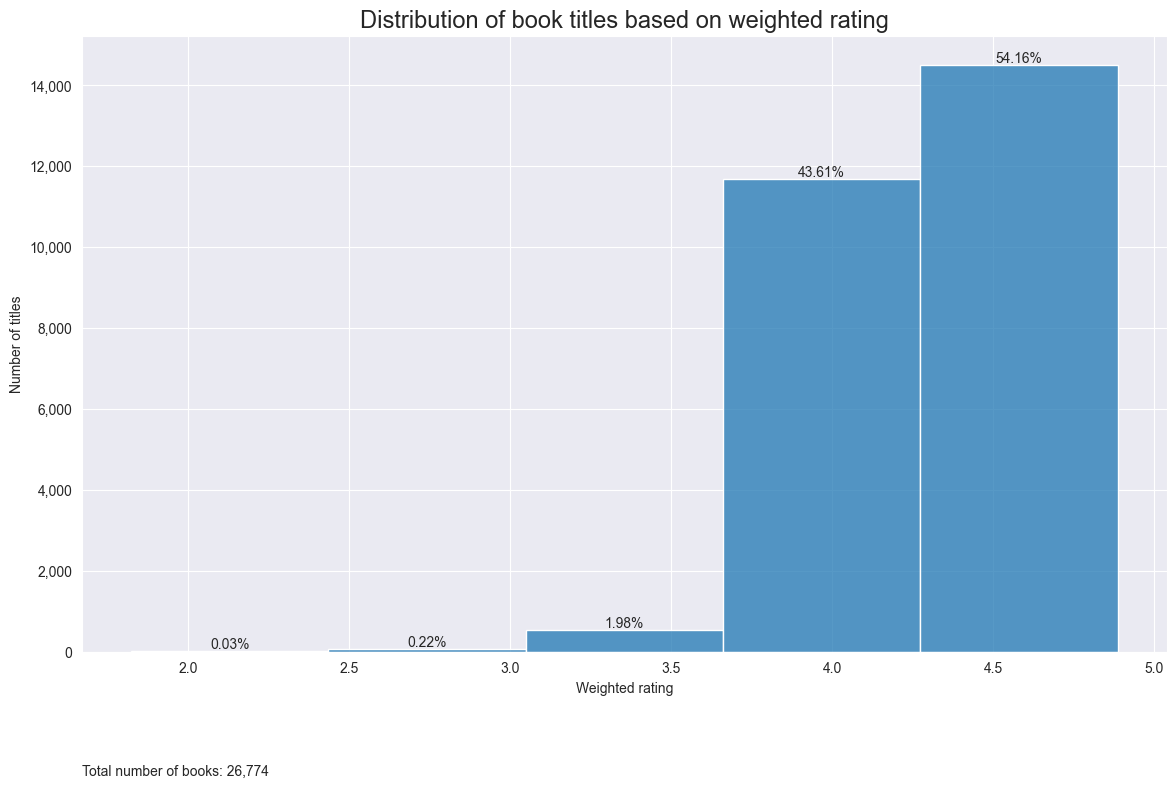

In [81]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

# plot weighthed rating overall

tot_books = y.shape[0]

# Set up number of bins
n_bins = 5
# Set up bin edges
bin_edges = np.linspace(0, 5, 6)  # Ensure bins start from 0 to 5 with 5 bins


# Create a new figure
plt.figure(
    figsize = (14, 8))
sns.set_style("darkgrid")

# Draw histogram using Seaborn
ax = sns.histplot(y['weighted rating'], bins=n_bins, kde=False)

# Compute the counts for each bin
counts, _ = np.histogram(y['weighted rating'], bins=n_bins)
counts = counts / len(y)  # Convert counts to percentages

# Add text on each column showing the % of observations in each bin
for rect, count in zip(ax.patches, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, f'{count:.2%}', ha='center', va='bottom')

# Add title and footnotes
plt.title("Distribution of book titles based on weighted rating", fontsize=17)
plt.xlabel("Weighted rating")
plt.ylabel("Number of titles")

# Add footnote
plt.text(0, -0.2, f"Total number of books: {tot_books:,}", fontsize=10, transform=ax.transAxes)

# Get the current axis
ax = plt.gca()

# Apply thousand separator to y-axis ticks
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


plt.savefig(
    os.path.join(
        output_folder,
        'Charts',
        '03 Weighted ratings dis.png'
    )
)
plt.show()


#### Weighted ratings train-test distribution

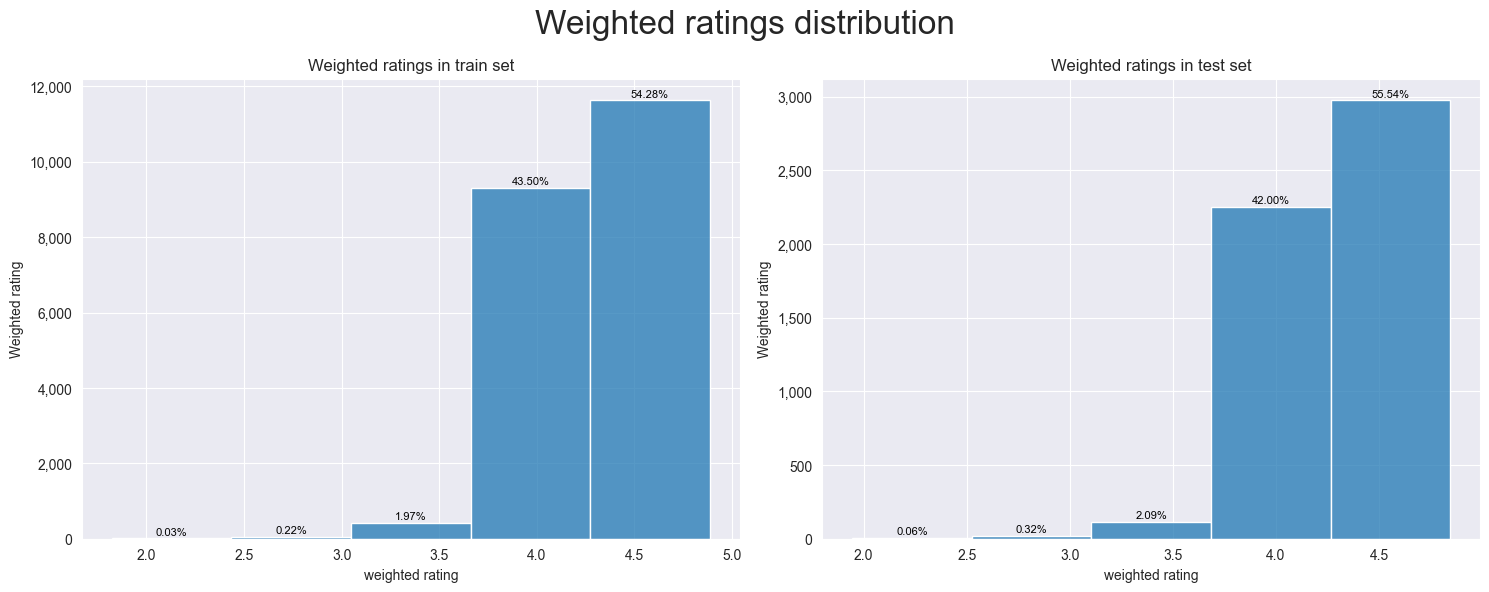

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

# Calculate percentage of observations in each bin for train and test sets
train_percentages = [count / len(y_wr_train) * 100 for count in np.histogram(y_wr_train, bins=n_bins)[0]]
test_percentages = [count / len(y_wr_test) * 100 for count in np.histogram(y_wr_test, bins=n_bins)[0]]

# Create subplots
fig, axes = plt.subplots(
    1, 
    2, 
    figsize=(15, 6))

# Histogram of weighted ratings in train set
sns.histplot(
    x=y_wr_train, 
    ax=axes[0],
    bins=n_bins, kde=False)
axes[0].set_title('Weighted ratings in train set')
axes[0].set_ylabel('Weighted rating')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Add thousands separator

# Annotate bars with percentage of observations for train set
for i, p in enumerate(axes[0].patches):
    axes[0].annotate(f'{train_percentages[i]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Histogram of weighted ratings in test set
sns.histplot(
    x=y_wr_test, 
    ax=axes[1],
    bins=n_bins, kde=False)
axes[1].set_title('Weighted ratings in test set')
axes[1].set_ylabel('Weighted rating')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Add thousands separator

# Annotate bars with percentage of observations for test set
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{test_percentages[i]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Set common title for the figure
plt.suptitle("Weighted ratings distribution", fontsize=24)

plt.tight_layout()
plt.savefig(
    os.path.join(
        output_folder,
        'Charts',
        '03 Weighted rating dis train test.png'
    )
)

plt.show()
